In [95]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, make_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
df = pd.read_csv('/kaggle/input/parkinson-disease-detection/Parkinsson disease.csv')

## Attribute Information:

1. name - ASCII subject name and recording number
2. MDVP:Fo(Hz) - Average vocal fundamental frequency
3. MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
4. MDVP:Flo(Hz) - Minimum vocal fundamental frequency
5. MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several

Measures of variation in fundamental frequency

6. MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude
7. NHR,HNR - Two measures of ratio of noise to tonal components in the voice
8. RPDE,D2 - Two nonlinear dynamical complexity measures
9. DFA - Signal fractal scaling exponent
10. spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation

## Target column: status - Health status of the subject (one) - Parkinson's, (zero) - healthy

In [97]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [99]:
sum(df.duplicated())

0

#### There are no null values or duplicated values

## Preprocessing

In [100]:
df.drop(columns = 'name', inplace = True)

In [101]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


### Check multicolinearity

<Axes: >

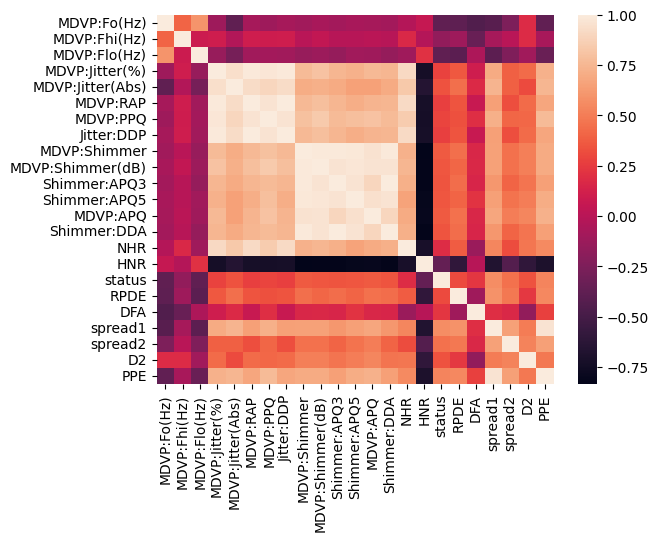

In [102]:
sns.heatmap(df.corr())

### Dropping Multicolinear features but leaving one single feature with the largest variance

In [103]:
df[['MDVP:Jitter(%)','MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP','MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5','MDVP:APQ', 'Shimmer:DDA']].var()

MDVP:Jitter(%)      2.350440e-05
MDVP:Jitter(Abs)    1.212565e-09
MDVP:RAP            8.807685e-06
MDVP:PPQ            7.611952e-06
Jitter:DDP          7.926954e-05
MDVP:Shimmer        3.555839e-04
MDVP:Shimmer(dB)    3.797716e-02
Shimmer:APQ3        1.030867e-04
Shimmer:APQ5        1.445695e-04
MDVP:APQ            2.871919e-04
Shimmer:DDA         9.277580e-04
dtype: float64

In [104]:
df_no_multicolin = df.drop(columns = ['MDVP:Jitter(%)','MDVP:Jitter(Abs)', 
                                      'MDVP:RAP', 'MDVP:PPQ', 'MDVP:Shimmer', 'Shimmer:APQ3', 
                                      'Shimmer:APQ5','MDVP:APQ', 'Shimmer:DDA', 'Jitter:DDP'])

<Axes: >

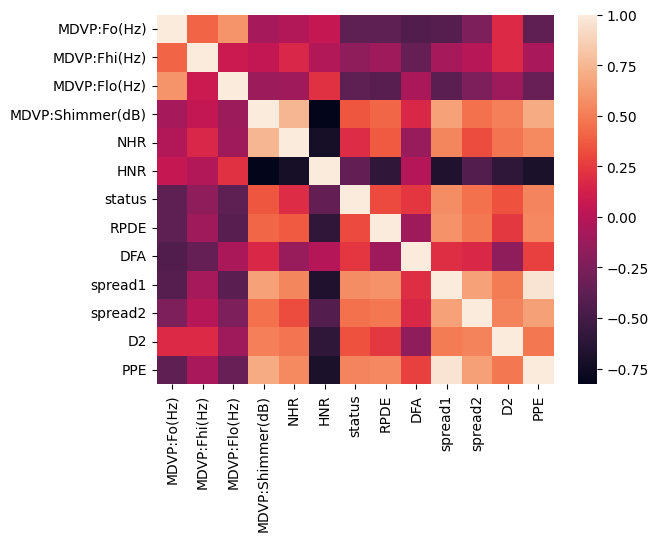

In [105]:
sns.heatmap(df_no_multicolin.corr())

### Drawing boxplots to see the outliers behavior

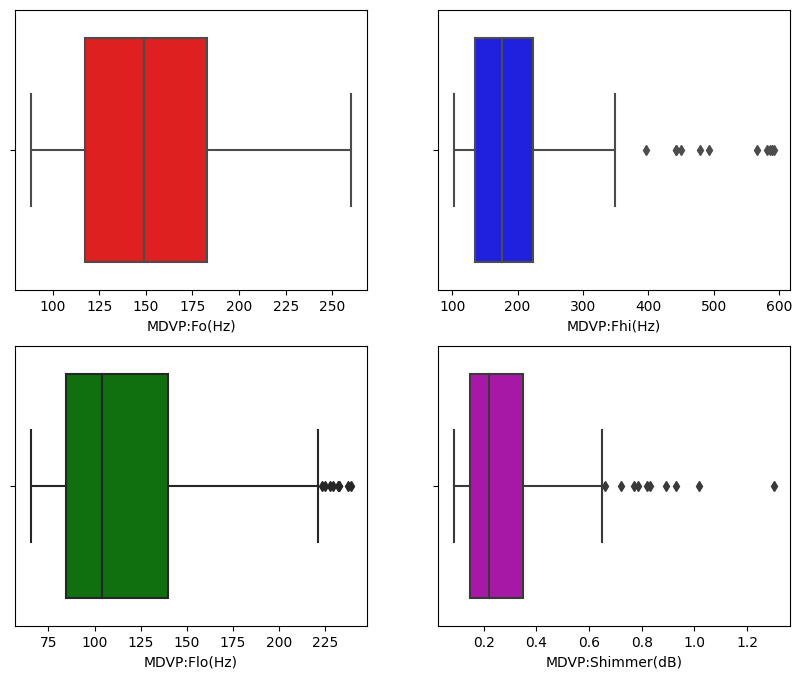

In [106]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
sns.boxplot(data = df_no_multicolin, x = 'MDVP:Fo(Hz)', ax = ax1, color = 'r')
sns.boxplot(data = df_no_multicolin, x = 'MDVP:Fhi(Hz)', ax = ax2, color = 'b')
sns.boxplot(data = df_no_multicolin, x = 'MDVP:Flo(Hz)', ax = ax3, color = 'g')
sns.boxplot(data = df_no_multicolin, x = 'MDVP:Shimmer(dB)', ax = ax4, color = 'm')
plt.show()

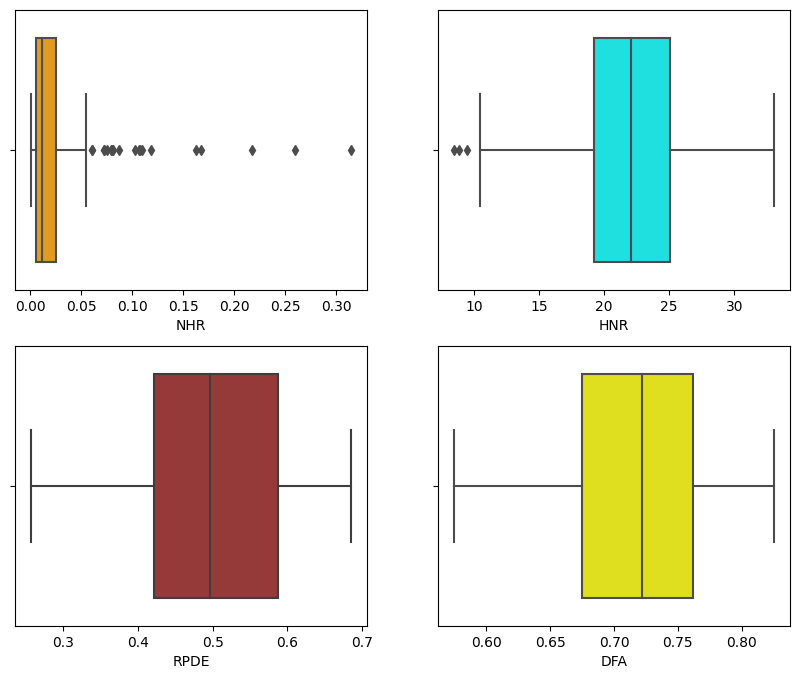

In [107]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
sns.boxplot(data = df_no_multicolin, x = 'NHR', ax = ax1, color = 'orange')
sns.boxplot(data = df_no_multicolin, x = 'HNR', ax = ax2, color = 'cyan')
sns.boxplot(data = df_no_multicolin, x = 'RPDE', ax = ax3, color = 'brown')
sns.boxplot(data = df_no_multicolin, x = 'DFA', ax = ax4, color = 'yellow')
plt.show()

### Is the dataset balanced?

In [108]:
df_no_multicolin['status'].value_counts()

status
1    147
0     48
Name: count, dtype: int64

#### Imbalanced classes our performance metrics must be f1_score not accuracy
#### We may need to perform upsampling

In [109]:
X = df.drop(columns = 'status')
y = df['status']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True, stratify = y, random_state = 42)

### 1st Algorithm: Random Forest Classifier

In [111]:
ss = StandardScaler()
rfc = RandomForestClassifier(random_state=42)

model = Pipeline([('scaler', ss), ('rfc', rfc)])

f1 = make_scorer(f1_score)

cv_results = cross_val_score(model, X_train, y_train, cv = 5, scoring = f1)

print("Cross Validation scores: ", cv_results)

model.fit(X_train, y_train)

y_preds = model.predict(X_test)
print("The f1 test score is", f1_score(y_test, y_preds))

Cross Validation scores:  [0.95454545 0.91666667 0.95652174 0.93023256 0.91304348]
The f1 test score is 0.9473684210526315


### Random Forest Classifier appears to be a suitable algorithm

<Axes: >

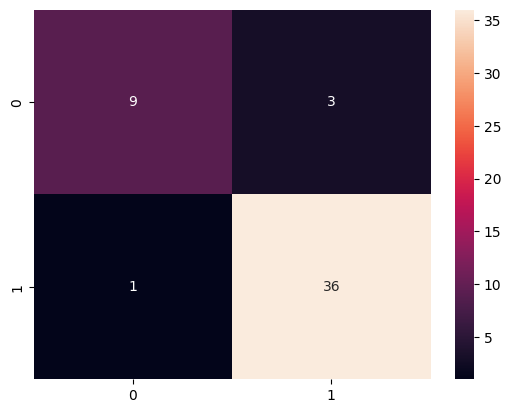

In [112]:
sns.heatmap(confusion_matrix(y_test, y_preds), annot = True)

### 2nd Algorithm: AdaBoostClassifier

In [113]:
from sklearn.ensemble import AdaBoostClassifier

ss = StandardScaler()
adaboost = AdaBoostClassifier(random_state=42)

model2 = Pipeline([('scaler', ss), ('adaboost', adaboost)])

f1 = make_scorer(f1_score)

cv_results2 = cross_val_score(model2, X_train, y_train, cv = 5, scoring = f1)

print("Cross Validation scores: ", cv_results2)

model2.fit(X_train, y_train)

y_preds2 = model2.predict(X_test)
print("The f1 test score is", f1_score(y_test, y_preds2))

Cross Validation scores:  [0.9        0.91304348 0.93333333 0.95454545 0.86363636]
The f1 test score is 0.9066666666666667


<Axes: >

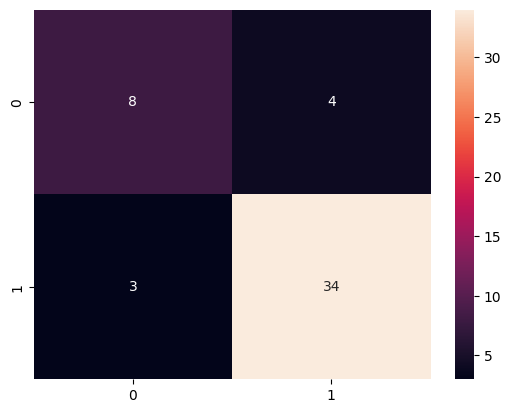

In [114]:
sns.heatmap(confusion_matrix(y_test, y_preds2), annot = True)

### The AdaBoostClassifier seem to overfit the data. Model tuning is required.

In [115]:
import xgboost as xgb

ss = StandardScaler()
xgb_class = xgb.XGBClassifier()

model3 = Pipeline([('scaler', ss), ('xgb', xgb_class)])

f1 = make_scorer(f1_score)

cv_results3 = cross_val_score(model3, X_train, y_train, cv = 5, scoring = f1)

print("Cross Validation scores: ", cv_results3)

model3.fit(X_train, y_train)

y_preds3 = model3.predict(X_test)
print("The f1 test score is", f1_score(y_test, y_preds3))

Cross Validation scores:  [0.95238095 0.91304348 0.95652174 0.95652174 0.93333333]
The f1 test score is 0.9473684210526315


### The XGBoostClassifier looks good as well

<Axes: >

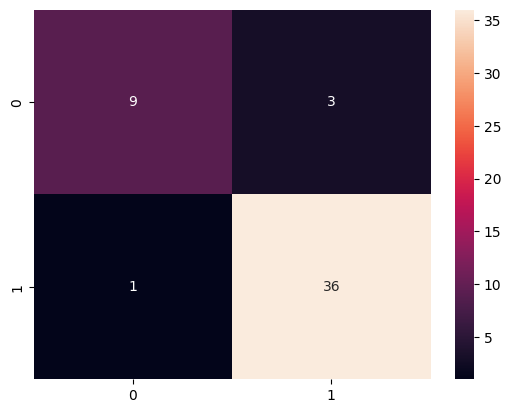

In [116]:
sns.heatmap(confusion_matrix(y_test, y_preds3), annot = True)

### Let's try using an Upsampler

In [117]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 147, 0: 147})


In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.25, shuffle = True, stratify = y_res, random_state = 42)

In [119]:
ss = StandardScaler()
rfc = RandomForestClassifier(random_state=42)

model = Pipeline([('scaler', ss), ('rfc', rfc)])

f1 = make_scorer(f1_score)

cv_results = cross_val_score(model, X_train, y_train, cv = 8, scoring = f1)

print("Cross Validation scores: ", cv_results)

model.fit(X_train, y_train)

y_preds = model.predict(X_test)
print("The f1 test score is", f1_score(y_test, y_preds))

Cross Validation scores:  [0.92307692 0.96296296 1.         0.88       0.96       0.96296296
 0.96296296 0.96296296]
The f1 test score is 0.9722222222222222


### F1 Score has increased

<Axes: >

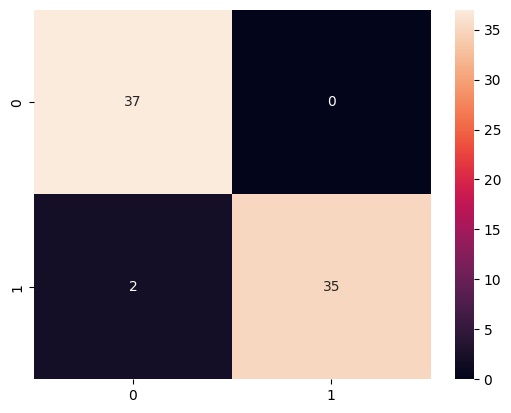

In [120]:
sns.heatmap(confusion_matrix(y_test, y_preds), annot = True)

In [121]:
ss = StandardScaler()
xgb_class = xgb.XGBClassifier()

model3 = Pipeline([('scaler', ss), ('xgb', xgb_class)])

f1 = make_scorer(f1_score)

cv_results3 = cross_val_score(model3, X_train, y_train, cv = 8, scoring = f1)

print("Cross Validation scores: ", cv_results3)

model3.fit(X_train, y_train)

y_preds3 = model3.predict(X_test)
print("The f1 test score is", f1_score(y_test, y_preds3))

Cross Validation scores:  [0.92307692 1.         1.         0.88       1.         0.96296296
 0.96551724 0.96296296]
The f1 test score is 0.9722222222222222


### The same conclusion applies to the xgboost

<Axes: >

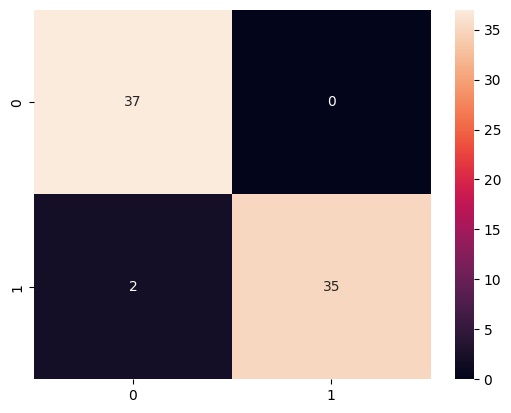

In [122]:
sns.heatmap(confusion_matrix(y_test, y_preds3), annot = True)

### Random Forest Feature Importance

In [123]:
importances = model.named_steps['rfc'].feature_importances_
feat_imp = pd.Series(importances, index = X_train.columns).sort_values()

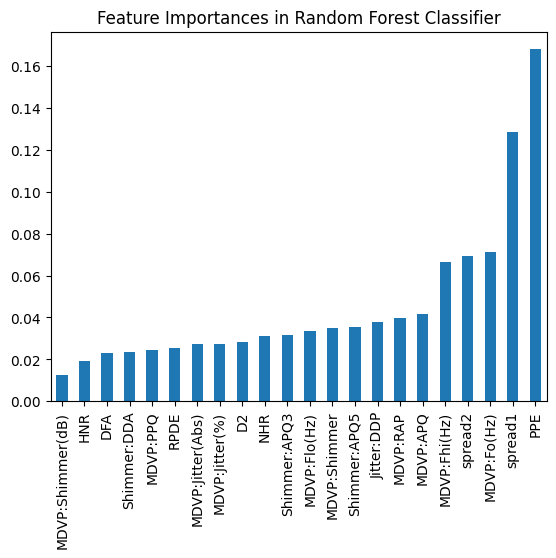

In [124]:
feat_imp.plot(kind = 'bar', title = 'Feature Importances in Random Forest Classifier');

### Random Forest Classifier Hyperparameter Tuning

In [125]:
from sklearn.model_selection import GridSearchCV
high_var_columns = ['PPE', 'spread1', 'MDVP:Fo(Hz)', 'spread2', 'MDVP:Fhi(Hz)']

param_grid = {'rfc__n_estimators': [80, 100, 120, 150],
              'rfc__max_depth': [10, 12, 14, 16]
             }
search = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, scoring = f1)
search.fit(X_train[high_var_columns], y_train)
search.best_score_

0.9578932178932178

In [126]:
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(max_depth=10, n_estimators=80,
                                        random_state=42))])

In [127]:
best_model = search.best_estimator_
predictions = best_model.predict(X_test[high_var_columns])
print("Best Model F1 Score: ", f1_score(y_test, predictions))

Best Model F1 Score:  0.9722222222222222
